In [1]:
import sys
sys.path.append("../") 

In [2]:
from __future__ import division

import argparse, time, logging, random, math

import numpy as np
import mxnet as mx

from mxnet import gluon, nd
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.,1.)
])

In [4]:
num_gpus = 0
model_ctx = mx.gpu()

num_workers = 0
batch_size = 256 
train_data = gluon.data.DataLoader(
    gluon.data.vision.MNIST(train=True).transform_first(transform),
    batch_size=batch_size, shuffle=True, last_batch='discard', num_workers=num_workers)

val_data = gluon.data.DataLoader(
    gluon.data.vision.MNIST(train=False).transform_first(transform),
    batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [5]:
for X,y in train_data:
    print(X.shape)
    print(y.shape)
    break

(256, 1, 28, 28)
(256,)


In [6]:
model_ctx

gpu(0)

In [7]:
type(X)

mxnet.numpy.ndarray

### Bayesian inference for MNIST

* [Stochastic Gradient Descent](#chapter1)
* [Stochastic Gradient Langevin Dynamics](#chapter2)
* [Bayes By Backprop](#chapter3)
* [Diagnostics](#chapter4)


# Stochastic Gradient Descent <a class="anchor" id="chapter1"></a>

In [8]:
import mxnet as mx
from mxnet import nd, autograd, gluon
hyper={'alpha':10.}
in_units=(1,28,28)
out_units=10

In [9]:
import mxnet as mx
from hamiltonian.inference.sgd import sgd
from hamiltonian.models.softmax import lenet

model=lenet(hyper,in_units,out_units,ctx=model_ctx)
inference=sgd(model,step_size=0.1,ctx=model_ctx)

In [10]:
import hamiltonian
import importlib

try:
    importlib.reload(hamiltonian.models.softmax)
    importlib.reload(hamiltonian.inference.sgd)
    print('modules re-loaded')
except:
    print('no modules loaded yet')


modules re-loaded


iteration 0, train loss: 16.4555, train accuracy : 0.0986
iteration 10, train loss: 16.5003, train accuracy : 0.0987
iteration 20, train loss: 16.5010, train accuracy : 0.0987
iteration 30, train loss: 16.5008, train accuracy : 0.0987
iteration 40, train loss: 6.3837, train accuracy : 0.0999
iteration 50, train loss: 6.4246, train accuracy : 0.1014
iteration 60, train loss: 6.4075, train accuracy : 0.1025
iteration 70, train loss: 6.4330, train accuracy : 0.1033
iteration 80, train loss: 6.4407, train accuracy : 0.1038
iteration 90, train loss: 6.2580, train accuracy : 0.1042


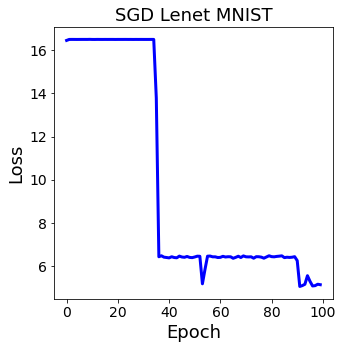

In [11]:
train_sgd=True
num_epochs=100
import h5py
import matplotlib.pyplot as plt

if train_sgd:
    par,loss=inference.fit(epochs=num_epochs,batch_size=batch_size,data_loader=train_data,
                           chain_name='lenet_map.h5',verbose=True)

    fig=plt.figure(figsize=[5,5])
    plt.plot(loss,color='blue',lw=3)
    plt.xlabel('Epoch', size=18)
    plt.ylabel('Loss', size=18)
    plt.title('SGD Lenet MNIST', size=18)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.savefig('sgd_lenet.pdf', bbox_inches='tight')
else:
    map_estimate=h5py.File('lenet_map.h5','r')
    par={var:map_estimate[var][:] for var in map_estimate.keys()}
    map_estimate.close()
    

In [ ]:
cum_loss=list()
params=model.net.collect_params()
momentum={var:mx.np.zeros_like(params[var].data()) for var in params.keys()}
for X,y in train_data:
    X=X.as_in_context(model_ctx)
    y=y.as_in_context(model_ctx)
    with autograd.record():
        loss=inference.loss(model.net.collect_params(),X_train=X,y_train=y)
    loss.backward()
    inference.step(momentum,params)
    cum_loss.append(loss.asnumpy())

In [ ]:
np.sum(cum_loss)/len(train_data)

In [ ]:
np.mean(cum_loss)

In [ ]:
y_pred=model.forward(model.net.collect_params(),X_train=X)

In [ ]:
y_hat=np.mean(y_pred.sample_n(100),axis=0)

In [ ]:
np.quantile(y_pred.sample_n(100),.5,axis=0).astype(y.dtype)

In [ ]:
loss

In [ ]:
model.net.collect_params()

In [ ]:
map_estimate=h5py.File('lenet_map.h5','r')
par={var:map_estimate[var][:] for var in map_estimate.keys()}
map_estimate.close()

In [ ]:
total_samples,total_labels,log_like=inference.predict(par,batch_size=batch_size,num_samples=100,data_loader=val_data)

In [ ]:
y_hat=np.quantile(total_samples,.5,axis=0)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(np.int32(total_labels),np.int32(y_hat)))

# Stochastic Gradient Langevin Dynamics <a class="anchor" id="chapter2"></a>

In [ ]:
from hamiltonian.inference.sgld import sgld
from hamiltonian.models.softmax import lenet

model=lenet(hyper,in_units,out_units,ctx=model_ctx)
inference=sgld(model,par,step_size=0.01,ctx=model_ctx)

In [ ]:
import hamiltonian
import importlib

try:
    importlib.reload(hamiltonian.models.softmax)
    importlib.reload(hamiltonian.inference.sgld)
    print('modules re-loaded')
except:
    print('no modules loaded yet')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

train_sgld=False
num_epochs=250

if train_sgld:
    loss,posterior_samples=inference.sample(epochs=num_epochs,batch_size=batch_size,
                                data_loader=train_data,
                                verbose=True,chain_name='lenet_posterior.h5')

    plt.rcParams['figure.dpi'] = 360
    sns.set_style("whitegrid")
    fig=plt.figure(figsize=[5,5])
    plt.plot(loss[0],color='blue',lw=3)
    plt.plot(loss[1],color='red',lw=3)
    plt.xlabel('Epoch', size=18)
    plt.ylabel('Loss', size=18)
    plt.title('SGLD Lenet MNIST', size=18)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.savefig('sgld_lenet.pdf', bbox_inches='tight')


In [ ]:
import h5py 

posterior_samples=h5py.File('lenet_posterior.h5','r')

In [ ]:
total_samples,total_labels,log_like=inference.predict(posterior_samples,data_loader=val_data)

In [ ]:
from sklearn.metrics import classification_report
posterior_samples

y_hat=np.quantile(total_samples,.5,axis=0)

print(classification_report(np.int32(total_labels),np.int32(y_hat)))

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp

samples={var:posterior_samples[var] for var in posterior_samples.keys()}
samples={var:np.swapaxes(samples[var],0,1) for var in model.par}
r_hat_estimate = lambda samples : tfp.mcmc.diagnostic.potential_scale_reduction(samples, independent_chain_ndims=1,split_chains=False).numpy()
rhat = {var:r_hat_estimate(samples[var]) for var in model.par}
median_rhat_flat={var:np.median(rhat[var]) for var in rhat}

In [ ]:
labels, data = rhat.keys(), rhat.values()
flatten_data=list()
for d in data:
    flatten_data.append(d.reshape(-1))

plt.rcParams['figure.dpi'] = 360
sns.set_style("whitegrid")
plt.boxplot(flatten_data)
plt.xticks(range(1, len(labels) + 1), labels)
plt.title('Rhat')
plt.savefig('rhat_nonhierarchical_lenet.pdf', bbox_inches='tight')

In [ ]:
ess_estimate = lambda samples : tfp.mcmc.diagnostic.effective_sample_size(samples, filter_beyond_positive_pairs=False,cross_chain_dims=1).numpy()
ess = {var:ess_estimate(samples[var]) for var in model.par}
median_ess_flat={var:np.median(ess[var]) for var in ess}

In [ ]:
labels, data = ess.keys(), ess.values()
flatten_data=list()
for d in data:
    flatten_data.append(d.reshape(-1))
plt.rcParams['figure.dpi'] = 360
sns.set_style("whitegrid")    
plt.boxplot(flatten_data)
plt.xticks(range(1, len(labels) + 1), labels)
plt.title('ESS')
plt.savefig('ess_nonhierarchical_lenet.pdf', bbox_inches='tight')

In [ ]:
from hamiltonian.utils.psis import *

loo,loos,ks=psisloo(log_like)
max_ks=max(ks[~ np.isinf(ks)])

In [ ]:
flat_ks_1=np.sum(ks>1)
flat_ks_7_1=np.sum(np.logical_and(ks>0.7,ks<1))
flat_ks_5_7=np.sum(np.logical_and(ks>0.5,ks<0.7))
flat_ks_5=np.sum(ks<0.5)

# Hierarchical Lenet <a class="anchor" id="chapter3"></a>

In [ ]:
from hamiltonian.inference.sgld import hierarchical_sgld
from hamiltonian.models.softmax import hierarchical_lenet

model=hierarchical_lenet(hyper,in_units,out_units,ctx=model_ctx)
inference=hierarchical_sgld(model,par,step_size=0.001,ctx=model_ctx)

In [ ]:
import hamiltonian
import importlib

try:
    importlib.reload(hamiltonian.models.softmax)
    importlib.reload(hamiltonian.inference.sgld)
    print('modules re-loaded')
except:
    print('no modules loaded yet')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import glob

train_sgld=True
num_epochs=250

if train_sgld:
    loss,posterior_samples=inference.sample(epochs=num_epochs,batch_size=batch_size,
                                data_loader=train_data,
                                verbose=True,chain_name='hierarchical_lenet_posterior.h5')

    plt.rcParams['figure.dpi'] = 360
    sns.set_style("whitegrid")
    fig=plt.figure(figsize=[5,5])
    plt.plot(loss[0],color='blue',lw=3)
    plt.plot(loss[1],color='red',lw=3)
    plt.xlabel('Epoch', size=18)
    plt.ylabel('Loss', size=18)
    plt.title('SGLD Hierarchical Lenet MNIST', size=18)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.savefig('sgld_hierarchical_lenet.pdf', bbox_inches='tight')


In [ ]:
import h5py 

posterior_samples=h5py.File('hierarchical_lenet_posterior.h5','r')

In [ ]:
total_samples,total_labels,log_like=inference.predict(posterior_samples,data_loader=val_data)

In [ ]:
from sklearn.metrics import classification_report


y_hat=np.quantile(total_samples,.5,axis=0)

print(classification_report(np.int32(total_labels),np.int32(y_hat)))

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp

samples={var:posterior_samples[var] for var in posterior_samples.keys()}
samples={var:np.swapaxes(samples[var],0,1) for var in model.par}
r_hat_estimate = lambda samples : tfp.mcmc.diagnostic.potential_scale_reduction(samples, independent_chain_ndims=1,split_chains=True).numpy()
rhat = {var:r_hat_estimate(samples[var]) for var in model.par}
median_rhat_hierarchical={var:np.median(rhat[var]) for var in rhat}

In [ ]:
labels, data = rhat.keys(), rhat.values()
flatten_data=list()
for d in data:
    flatten_data.append(d.reshape(-1))

plt.rcParams['figure.dpi'] = 360
sns.set_style("whitegrid")
plt.boxplot(flatten_data)
plt.xticks(range(1, len(labels) + 1), labels)
plt.title('Rhat')
plt.savefig('rhat_hierarchical_lenet.pdf', bbox_inches='tight')

In [ ]:
ess_estimate = lambda samples : tfp.mcmc.diagnostic.effective_sample_size(samples, filter_beyond_positive_pairs=False,cross_chain_dims=1).numpy()
ess = {var:ess_estimate(samples[var]) for var in model.par}
median_ess_hierarchical={var:np.median(ess[var]) for var in ess}

In [ ]:
labels, data = ess.keys(), ess.values()
flatten_data=list()
for d in data:
    flatten_data.append(d.reshape(-1))
plt.rcParams['figure.dpi'] = 360
sns.set_style("whitegrid")    
plt.boxplot(flatten_data)
plt.xticks(range(1, len(labels) + 1), labels)
plt.title('ESS')
plt.savefig('ess_hierarchical_lenet.pdf', bbox_inches='tight')

In [ ]:
from hamiltonian.utils.psis import *

loo,loos,ks=psisloo(log_like)
max_ks=max(ks[~ np.isinf(ks)])

In [ ]:
hierarchical_ks_1=np.sum(ks>1)
hierarchical_ks_7_1=np.sum(np.logical_and(ks>0.7,ks<1))
hierarchical_ks_5_7=np.sum(np.logical_and(ks>0.5,ks<0.7))
hierarchical_ks_5=np.sum(ks<0.5)

In [ ]:
import pandas as pd

hierarchical=[hierarchical_ks_1,hierarchical_ks_7_1,hierarchical_ks_5_7,hierarchical_ks_5]
flat=[flat_ks_1,flat_ks_7_1,flat_ks_5_7,flat_ks_5]
index = ['k>1', '0.7<k<1', '0.5<k<0.7','k<0.5']
df = pd.DataFrame({'hierarchical': hierarchical,
                   'non-hierarchical': flat}, index=index)
ax = df.plot.bar(rot=0)
plt.title('Pareto K shape')

In [ ]:
hierarchical=median_rhat_hierarchical.values()
flat=median_rhat_flat.values()
index = median_rhat_flat.keys()
df = pd.DataFrame({'hierarchical': hierarchical,
                   'non-hierarchical': flat}, index=index)
ax = df.plot.bar(rot=0)
plt.title('Potential Scale Reduction (Rhat)')

In [ ]:
hierarchical=median_ess_hierarchical.values()
flat=median_ess_flat.values()
index = median_ess_flat.keys()
df = pd.DataFrame({'hierarchical': hierarchical,
                   'non-hierarchical': flat}, index=index)
ax = df.plot.bar(rot=0)
plt.title('ESS')